In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

## Loading CSVs into dict

In [2]:
# Reload vejledninger_html_2-11-2023.csv into vejledninger_html_dict as key,value pairs
import csv
import sys
csv.field_size_limit(sys.maxsize)

vejledninger_tekst_dict = {}
csv_file_path = 'data/vejledninger_tekst_8-11-2023.csv'
with open(csv_file_path, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    #Skip first row
    next(reader)

    for row in reader:
        key = row[0]
        value = row[1]
        vejledninger_tekst_dict[key] = value

In [3]:
print(f'A total of {len(vejledninger_tekst_dict)} vejledninger were loaded into vejledninger_html_dict.')

A total of 431 vejledninger were loaded into vejledninger_html_dict.


In [4]:
vejledninger_tekst_dict['Vejledning om ret til dagpenge efter barselsloven ved pasning af alvorligt syge børn'][3000:5000]

'bejdsfortjeneste ved pasning af et handicappet barn i hjemmet. Der kan dog kun udbetales ydelser efter det ene af de to regelsæt. Udbetaling Danmark skal vejlede forældre, der kan være omfattet af begge regelsæt om reglerne. Udbetaling Danmark skal blandt andet oplyse forældrene om, at de kan søge om tabt arbejdsfortjeneste fra kommunen, og at forældre, som både opfylder betingelserne for at få dagpenge efter barselsloven og tabt arbejdsfortjeneste efter serviceloven, har mulighed for at vælge mellem de to regelsæt. Der henvises til Ankestyrelsens principafgørelse 23-15.\n\n2.Personkreds\n2.1.Forældre/adoptivforældre\nAnkestyrelsen har i principmeddelelse 15-22 slået fast, at forældrebegrebet i barselsloven forstås som far, mor og medmor og fortolkes i overensstemmelse med børnelovens regler.\nBørneloven anerkender alene far, mor og medmor som forældre til et barn. Andre personer, f.eks. stedforældre eller bedsteforældre, er derimod ikke omfattet af den berettigede personkreds.\nDen p

### Load into Llamaindex documents
Esentially just dicts with text and metadata

In [5]:
from llama_index import Document
documents_vejledninger = [Document(text=content, metadata={"file_name": name}) for name, content in vejledninger_tekst_dict.items()]

## Chunking text

In [58]:
from llama_index.node_parser import SentenceSplitter
from transformers import AutoTokenizer

#Setting max length and defining tokenizer as intended embedding model (e5)
node_parser = SentenceSplitter(chunk_size=512, 
                               chunk_overlap=0, 
                               paragraph_separator="\n\n", 
                               tokenizer=AutoTokenizer.from_pretrained('intfloat/e5-base-v2').tokenize
                               )


nodes_vejledninger = node_parser.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (16295 > 512). Running this sequence through the model will result in indexing errors


In [59]:
nodes_vejledninger[9].text

'Det er det timetal, der er indberettet til indkomstregistret, der skal medregnes. Ved beskæftigelse, der i henhold til aftale eller gældende overenskomst anses som fuldtidsbeskæftigelse, selv om det udføres på kortere end normal arbejdstid, medregnes med 37 timer ugentligt, hvis der er indberettet 37 timer til indkomstregistret.\n\nLøntimerne kan medregnes til opfyldelse af beskæftigelseskravet, hvis timerne er indberettet til indkomstregisteret for 4 måneders perioden.\n\nTimer, der er indberettet for en periode, som går over flere kalendermåneder, skal fordeles forholdsmæssigt på kalendermånederne, jf. bekendtgørelsens § 2, stk. 4. I disse tilfælde håndteres indberetningen sådan, at både beløb og timetal fordeles efter antal kalenderdage på de måneder, der er berørt af indberetningen. En indberetning, der har startdato 17. januar 2022 og slutdato 10. februar 2022, vil således blive fordelt med 15 dage i januar og 10 dage i februar. 60 pct. af timerne og indkomsten vil således blive 

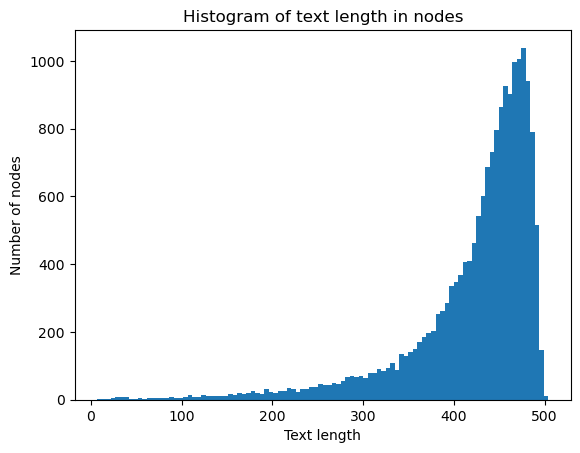

In [61]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
for text in [node.text for node in nodes_vejledninger]:
    token_counts.append(len(tokenizer.tokenize(text)))

# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Text length')
plt.ylabel('Number of nodes')
plt.show()


In [62]:
#Print first 5 examples of texts under 100 tokens
for i in range(5):
    print(f'Example {i+1} of texts under 100 tokens:')
    print([node.text for node in nodes_vejledninger if len(tokenizer.tokenize(node.text)) < 100][i])
    print('\n')

Example 1 of texts under 100 tokens:
Baggrund
At-vejledningen knytter sig til bekendtgørelsen om arbejdsmiljøfaglige uddannelser.

At-meddelelse 2.01.2 om gaffeltruckførercertifikat ophæves den 31. december 2017.

Arbejdstilsynet, den 22. november 2017


Example 2 of texts under 100 tokens:
skadedatoen.
Arbejdsskadestyrelsen, den 31. december  

 2000
Anne Lind Madsen
/Bent Mathiesen


Example 3 of texts under 100 tokens:
Årlig erstatning fra 1. januar 2021: 85.209,71 kr. × 1,536 = 130.882,11 kr., som forhøjes til nærmeste med 12 delelige kronebeløb: 130.884 kr.
Månedlig erstatning: 10.907 kr.


Example 4 of texts under 100 tokens:
A-kassens afgørelse skal indeholde klagevejledning, jf. § 3, stk. 1, i bekendtgørelse nr. 908 af 1. september 2004 om klage over a-kassernes afgørelser.
A-kassernes afgørelser skal i øvrigt indeholde følgende elementer:


Example 5 of texts under 100 tokens:
Det gælder også i tilfælde, hvor forældrene tilsammen har modtaget dagpenge med et højere dagpengebel

In [6]:
from llama_index.node_parser import SentenceSplitter
from transformers import AutoTokenizer
from llama_index.callbacks import CallbackManager, TokenCountingHandler
import tiktoken

node_parser_not_token = SentenceSplitter(chunk_size=512, 
                               chunk_overlap=0, 
                               paragraph_separator="\n\n",
                               )


nodes_vejledninger_not_token = node_parser_not_token.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


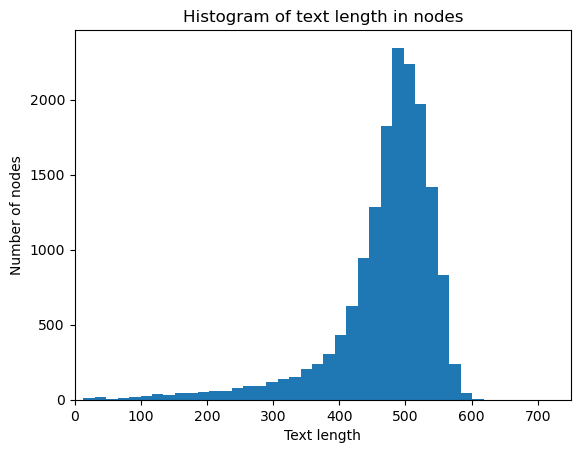

In [8]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
for text in [node.text for node in nodes_vejledninger_not_token]:
    token_counts.append(len(tokenizer.tokenize(text)))

# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Text length')
plt.xlim(0, 750)
plt.ylabel('Number of nodes')
plt.show()


### Langchain

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def e5_len(text):
    return len(tokenizer.tokenize(text))

langchain_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 512,
    chunk_overlap  = 0,
    length_function = e5_len,
)

In [30]:
langchain_texts = langchain_text_splitter.create_documents([document.text for document in documents_vejledninger])

Token indices sequence length is longer than the specified maximum sequence length for this model (785 > 512). Running this sequence through the model will result in indexing errors


In [14]:
len(langchain_texts)

18388

In [31]:
langchain_texts[0].page_content

'Vejledning om beskæftigelseskravet for ret til barselsdagpenge\n\n1.Indledning\nI denne vejledning beskrives hvilke beskæftigelseskrav, der gælder for at opnå ret til barselsdagpenge. Reglerne findes i §§ 27-29 i barselsloven (loven).\n\nI bekendtgørelse nr. 1090 af 1. juni 2021 om opgørelse af beskæftigelseskrav og beregning af barselsdagpenge m.v. (bekendtgørelsen) er fastsat nærmere regler om opgørelsen af beskæftigelseskravet.\n\nDenne vejledning erstatter vejledning nr. 10066 af 29. december 2020 om beskæftigelseskravet for ret til barselsdagpenge.\n\nEn lønmodtager har ret til barselsdagpenge, hvis pågældende opfylder ét af de fem krav om tilknytning til arbejdsmarkedet, der er nævnt i lovens § 27, stk. 1.\n\nKravet om aktuel beskæftigelse dagen før fraværet eller på første fraværsdag samt beskæftigelse i mindst 160 timer indberettet i indkomstregistret inden for de seneste 4 afsluttede kalendermåneder forud for fraværsperioden, jf. lovens § 27, stk. 1, nr. 1, er beskrevet i pkt

In [29]:
langchain_texts[1].page_content

'Kravet om inden for den seneste måned at have afsluttet en erhvervsmæssig uddannelse af mindst 18 måneders varighed, jf. lovens § 27, stk. 1, nr. 4, er beskrevet i pkt. 2.3.\n\nKravet om at være elev i lønnet praktik i en uddannelse, der er reguleret ved eller i henhold til lov, jf. lovens § 27, stk. 1, nr. 5, er beskrevet i pkt. 2.4.\n\nKravet om at være ansat i fleksjob, jf. lovens § 27, stk. 1, nr. 6, er beskrevet i pkt. 2.5.'

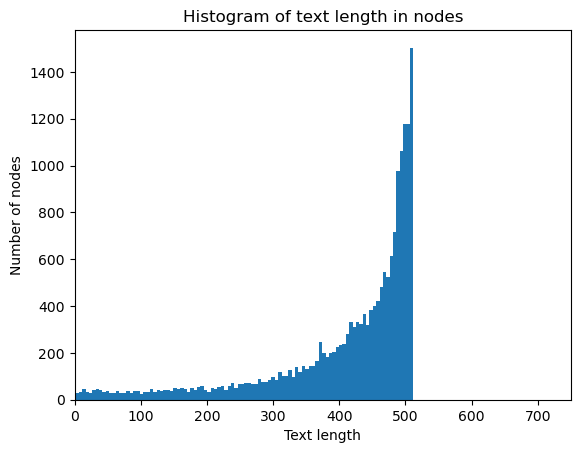

In [36]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-base-v2')
token_counts = []
#Iterate over .page_content of each langchain_text
for text in [str(text.page_content) for text in langchain_texts]:
    token_counts.append(len(tokenizer.tokenize(text)))

# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

#Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt
import numpy as np
text_len = token_counts
plt.hist(text_len, bins=100)
plt.title('Histogram of text length in nodes')
plt.xlabel('Text length')
plt.xlim(0, 750)
plt.ylabel('Number of nodes')
plt.show()


In [37]:
#Print first 5 examples of texts under 100 tokens

for i in range(5):
    print(f'Example {i+1} of texts under 100 tokens:')
    print([str(text.page_content) for text in langchain_texts if len(tokenizer.tokenize(str(text.page_content))) < 100][i])
    print('\n')

Example 1 of texts under 100 tokens:
Vejledning om lungesygdomme
Kapitel 7 i Vejledning om erhvervssygdomme anmeldt fra 1. januar 2005
Indhold


Example 2 of texts under 100 tokens:
2.Kronisk bronkitis/KOL (E.7)
2.1.Punkt på fortegnelsen
Sygdommen kronisk bronkitis/KOL er optaget på fortegnelsen over erhvervssygdomme (gruppe E, punkt 7).


Example 3 of texts under 100 tokens:
Sygdommen astma er optaget på fortegnelsen over erhvervssygdomme (gruppe E, punkt 8):


Example 4 of texts under 100 tokens:
4.Hvad må unge ikke arbejde med?
Unge på 13-14 år samt ældre unge, der stadig er omfattet af undervisningspligten, må ikke arbejde med noget, der kan være farligt for deres sikkerhed og sundhed.


Example 5 of texts under 100 tokens:
Arbejde med nanomaterialer
De vigtigste regler om forebyggelse af sundhedsfarlige påvirkninger ved arbejde med fremstillede nanomaterialer.
At-vejledning 9.3.1-1
November 2014 - Opdateret juli 2019




## Random stuff

In [19]:
from llama_index.node_parser import SimpleNodeParser

node_parser = SimpleNodeParser.from_defaults(chunk_size=512, chunk_overlap=20)
nodes = node_parser.get_nodes_from_documents(documents, show_progress=True)

Parsing nodes:   0%|          | 0/431 [00:00<?, ?it/s]

In [ ]:
from llama_index.node_parser import SentenceWindowNodeParser 

window_node_parser = SentenceWindowNodeParser(sentence_splitter,
                                              window_size=3,
                                              include_prev_next_rel=True,
                                              include_metadata=True)


window_nodes_vejledninger = window_node_parser.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

In [ ]:
text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)
service_context = ServiceContext.from_defaults(text_splitter=text_splitter)